Importing libraries and downlaoding the datasets using kaggle
---



In [42]:
# Library
# from google.colab import userdata
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from nltk.tokenize import word_tokenize
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn import metrics



In [2]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/admondtamang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/admondtamang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/admondtamang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Download dataset from kaggle and unzip only for google colab
# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# !kaggle datasets download -d kazanova/sentiment140
# ! unzip "sentiment140.zip"

**Data Exploration**

In [4]:
# Define column names
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv("./training.1600000.processed.noemoticon.csv",
                 names = columns,
                 encoding = "ISO-8859-1")

positive_rows = df[df['target'] == 4].head(2000)
negative_rows = df[df['target'] == 0].head(2000)

# Concatenate the positive and negative rows
df = pd.concat([positive_rows, negative_rows])

# Display the first few rows of the filtered DataFrame
print("\nFirst few rows of the filtered DataFrame:")
print(df.head())

# Optionally, display some info to verify the filtering
print("\nFiltered DataFrame info:")
print(df.info())

# Check the counts to ensure we have 1000 positive and 1000 negative
print("\nTarget value counts in the filtered DataFrame:")
print(df['target'].value_counts())





First few rows of the filtered DataFrame:
        target         ids                          date      flag  \
800000       4  1467822272  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800001       4  1467822273  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800002       4  1467822283  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800003       4  1467822287  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800004       4  1467822293  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   

               user                                               text  
800000        ersle       I LOVE @Health4UandPets u guys r the best!!   
800001     becca210  im meeting up with one of my besties tonight! ...  
800002    Wingman29  @DaRealSunisaKim Thanks for the Twitter add, S...  
800003    katarinka  Being sick can be really cheap when it hurts t...  
800004  _EmilyYoung    @LovesBrooklyn2 he has that effect on everyone   

Filtered DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 800000 to 199

In [5]:
# Dropping the redundent looking collumns (for this project)
to_drop = ['ids', 'date', 'flag', 'user']
df = df.drop(df[to_drop], axis=1)
df.head()

,target,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

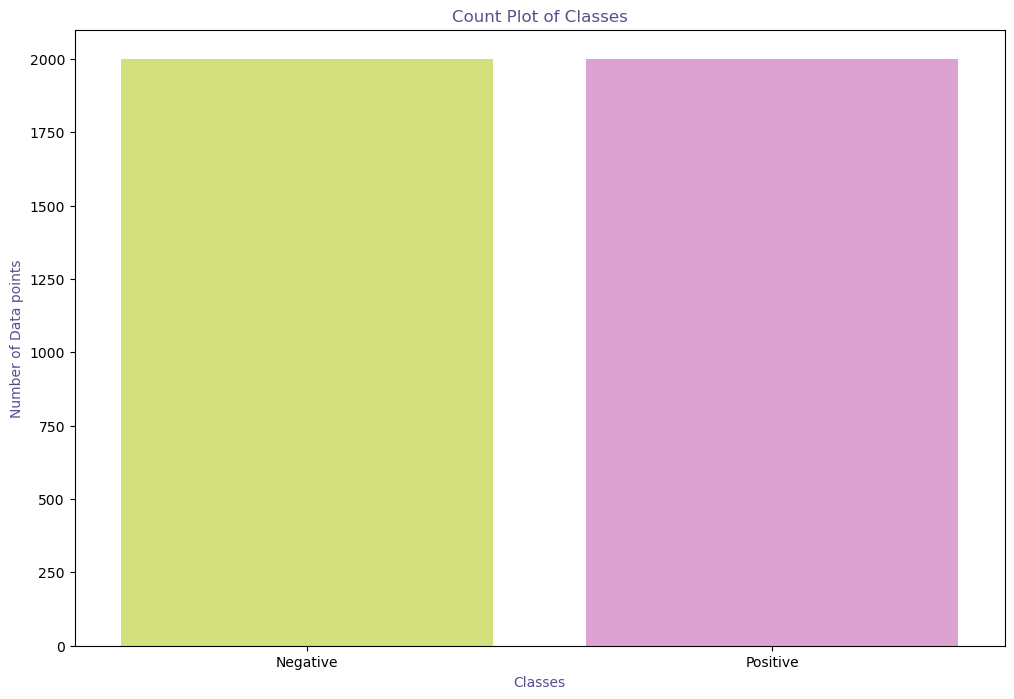

In [6]:
cols= ["#E1F16B", "#E598D8"]

#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= df["target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")
fg.set_xticklabels(["Negative", "Positive"])

**Feature Engineering**

In [7]:
#Adding a column of numbers of charachters,words and sentences in each msg
df["No_of_Characters"] = df["text"].apply(len)
df["No_of_Words"]=df.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,4000.0,2.00000,2.000250,0.0,0.0,2.0,4.0,4.0
No_of_Characters,4000.0,75.15875,36.432127,8.0,45.0,71.0,104.0,152.0
No_of_Words,4000.0,16.59350,8.563299,1.0,10.0,16.0,23.0,44.0
No_of_sentence,4000.0,1.74350,0.983082,1.0,1.0,1.0,2.0,11.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


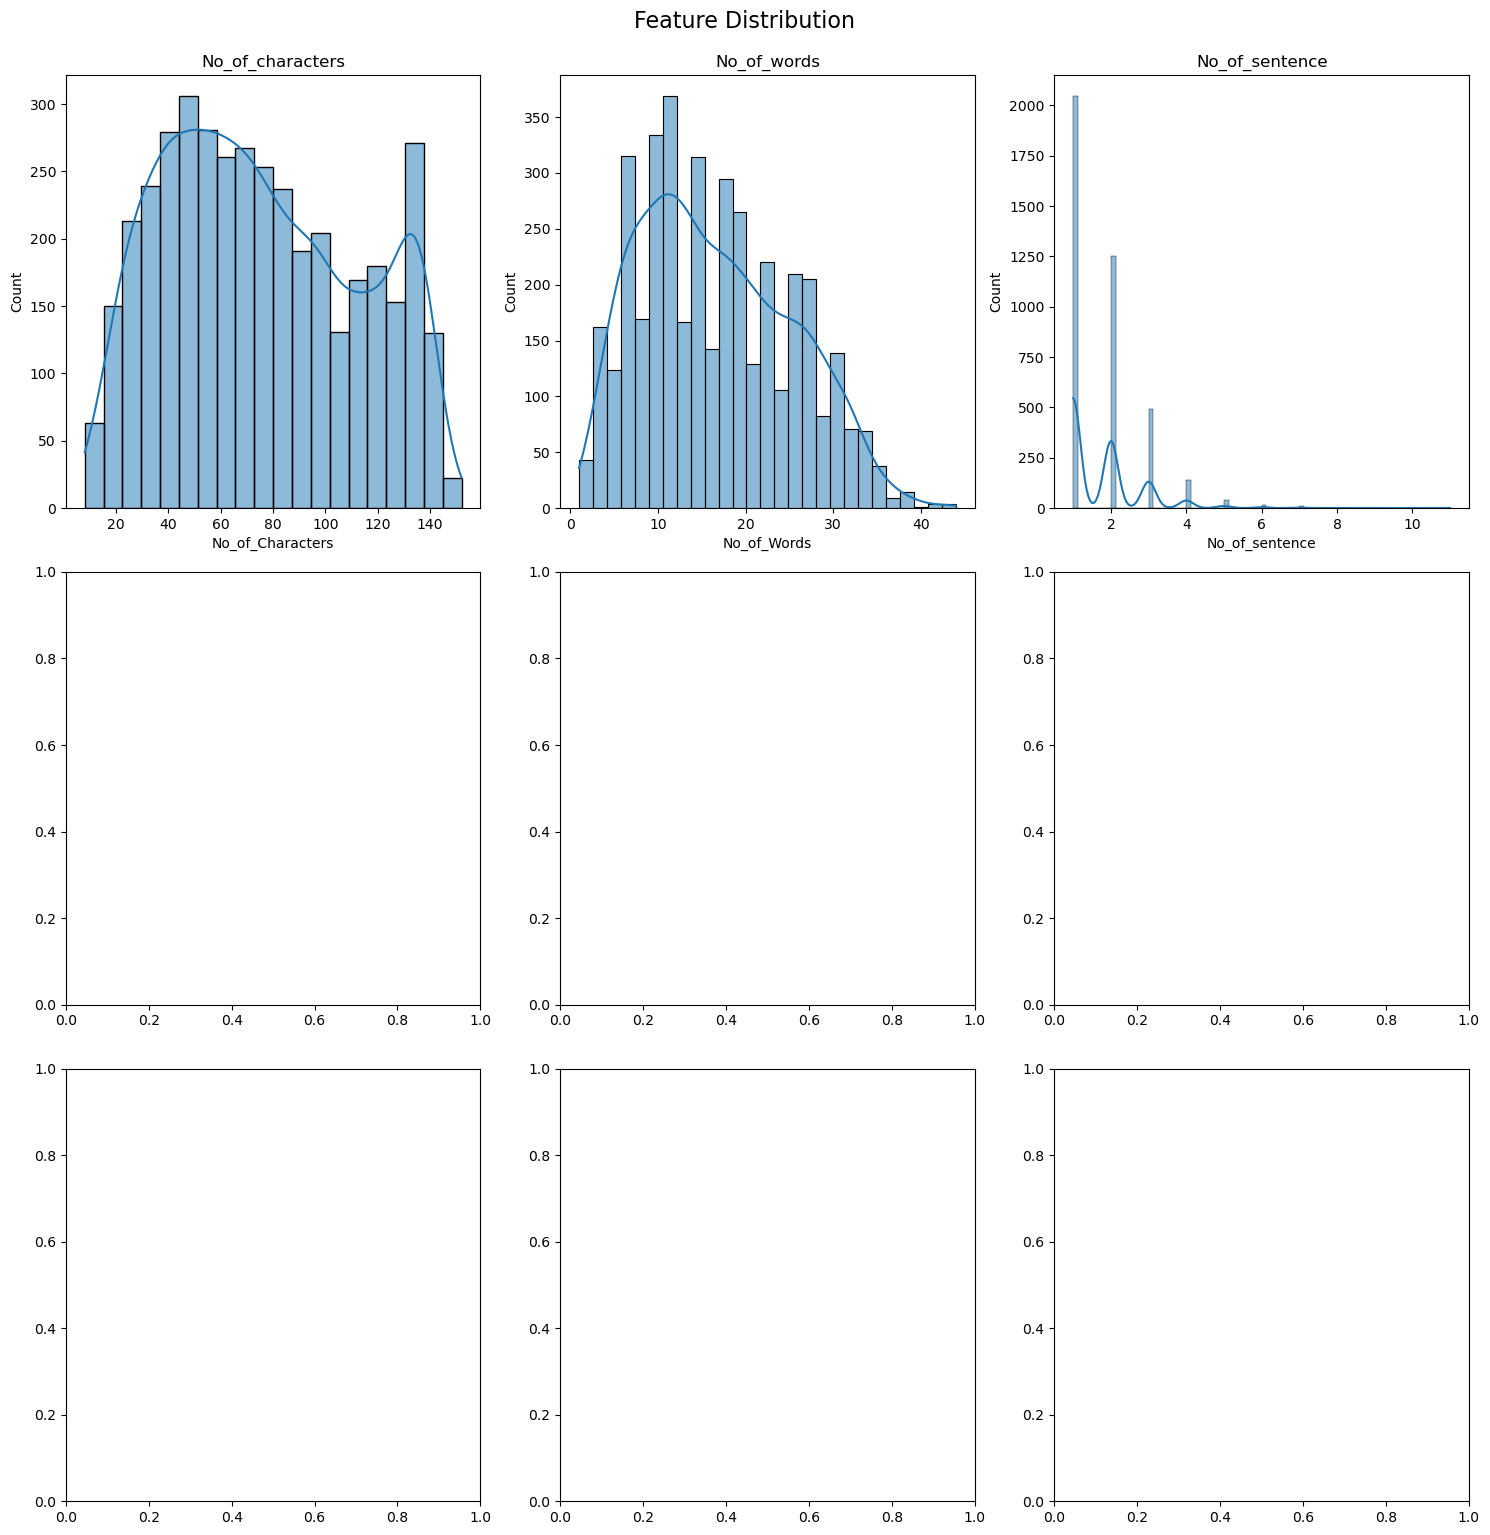

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

features = ['No_of_Characters', 'No_of_Words', 'No_of_sentence']

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    
    sns.histplot(df[feature], ax=axes[row, col], kde=True)
    axes[row, col].set_title(feature.capitalize())

plt.tight_layout()
plt.suptitle('Feature Distribution', fontsize=16, y=1.02)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x800 with 0 Axes>

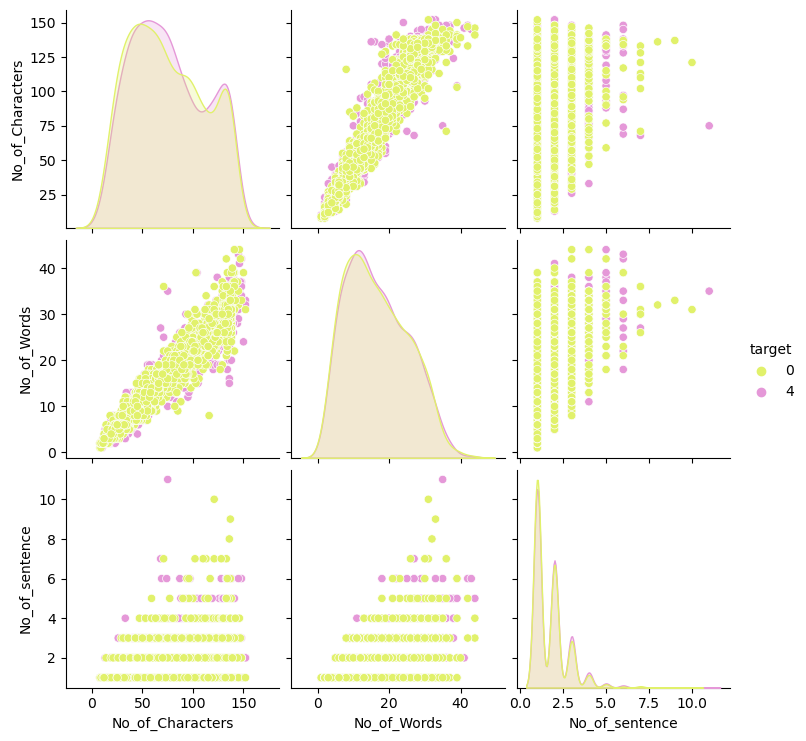

In [8]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="target",palette=cols)
plt.show(fg)

In [9]:
# Data pre-processing

import re

def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Removing html tags
        text = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",text)

        # Remove mentions
        text = re.sub(r'@\w+', '', text)

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Removing words that have numbers
        text = re.sub(r"\w*\d\w*", " ", text)

        # Removing Digits
        text = re.sub(r"[0-9]+", " ", text)

        # Cleaning white spaces
        text = re.sub(r"\s+", " ", text).strip()

        return text;
    else:
        return ''  # Return empty string for non-string inputs


df['text'] = df['text'].apply(preprocess_text)

print(df['text'])
df.head()

800000                             i love u guys r the best
800001    im meeting up with one of my besties tonight c...
800002    thanks for the twitter add sunisa i got to mee...
800003    being sick can be really cheap when it hurts t...
800004                       he has that effect on everyone
                                ...                        
1995                                            yep a loser
1996      and finito all bathroom contractors been thru ...
1997        awww that sucks are you going to the sydney one
1998      sorry sf rescheduling my sf trip for this comi...
1999      morw i get my blasted wisdom teeth pulled need...
Name: text, Length: 4000, dtype: object


,target,text,No_of_Characters,No_of_Words,No_of_sentence
800000,4,i love u guys r the best,44,11,2
800001,4,im meeting up with one of my besties tonight c...,72,19,4
800002,4,thanks for the twitter add sunisa i got to mee...,137,31,2
800003,4,being sick can be really cheap when it hurts t...,104,22,1
800004,4,he has that effect on everyone,47,8,1


In [10]:
df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1)


In [11]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)

In [12]:

# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["text"] = df["Tokenize_Text"].apply(remove_stopwords)

In [13]:
corpus= []
for i in df["text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

# show first five elements
corpus[:5]

['love u guys r best',
 'im meeting one besties tonight cant wait girl talk',
 'thanks twitter add sunisa got meet hin show dc area sweetheart',
 'sick really cheap hurts much eat real food plus friends make soup',
 'effect everyone']

In [14]:

tfidf = TfidfVectorizer(min_df=2)
X = tfidf.fit_transform(corpus).toarray()

#Let's have a look at our feature
X.dtype


#Label encode the Target and use it as y
label_encoder = LabelEncoder()
df["target"] = label_encoder.fit_transform(df["target"])

**Model Building**

In [15]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = df["target"]
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}


In [17]:

# Cossvalidation
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))



NaiveBayes: 0.680312 
RandomForest: 0.658125 
KNeighbours: 0.542813 
SVC: 0.688125 


**EVALUATING MODELS**

In [59]:
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []


for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)

    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)
    

In [58]:
feature_importances_list = []

for i, cls in enumerate(classifiers):
    # Train the classifier
    cls.fit(X_train, y_train)

    # Calculate feature importances (only for applicable models)
    if isinstance(cls, RandomForestClassifier):  # Check if classifier supports feature importance
        importances = cls.feature_importances_
        feature_importances_list.append(importances)
    else:
        feature_importances_list.append(None)  # Placeholder for non-applicable models

# Example usage (assuming Random Forest was the first classifier):
if feature_importances_list[0] is not None:
    importances = feature_importances_list[0]
    columns = X.columns
    df_plot = pd.DataFrame(np.array([importances]), columns=columns)
    df_plot.plot(kind='barh', figsize=(10, 6))
    plt.show()


In [19]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [20]:
# @title
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)


,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.725131,0.656398,0.689055,0.686250,0.967500
RandomForest,0.715640,0.715640,0.715640,0.686250,0.967500
KNeighbours,0.719008,0.206161,0.320442,0.686250,0.967500
SVC,0.709046,0.687204,0.697954,0.686250,0.967500


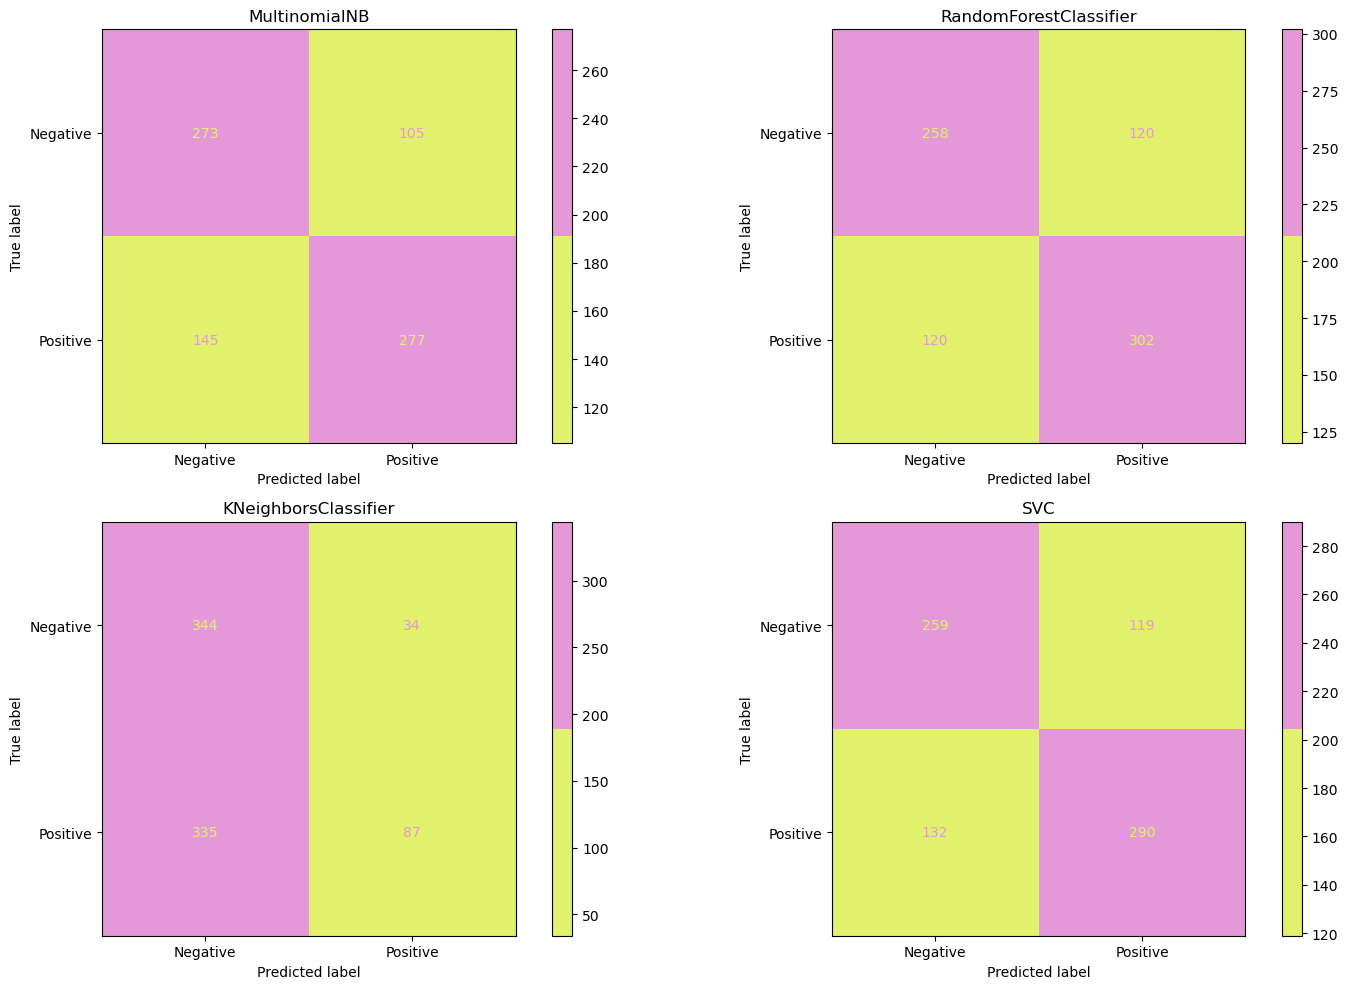

In [21]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# Define target names
target_names = ["Negative", "Positive"]

# Plot confusion matrices
for cls, ax in zip(classifiers, axes.flatten()):
    disp = ConfusionMatrixDisplay.from_estimator(cls, 
                                                 X_test, 
                                                 y_test, 
                                                 ax=ax, 
                                                 cmap=cmap,
                                                 display_labels=target_names)
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

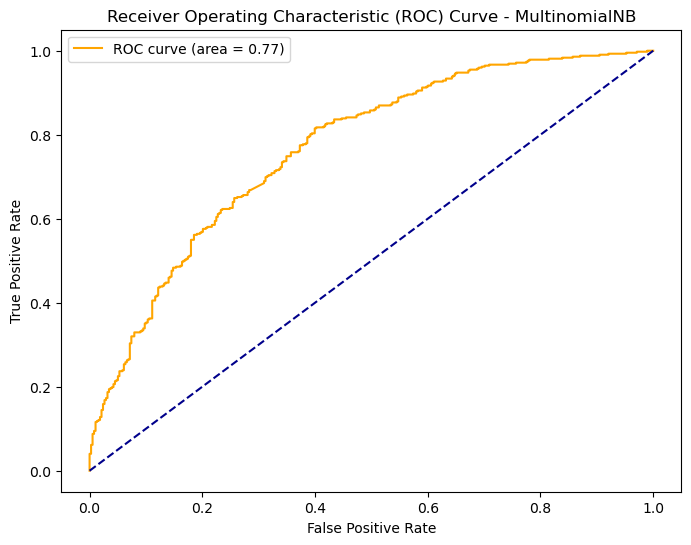

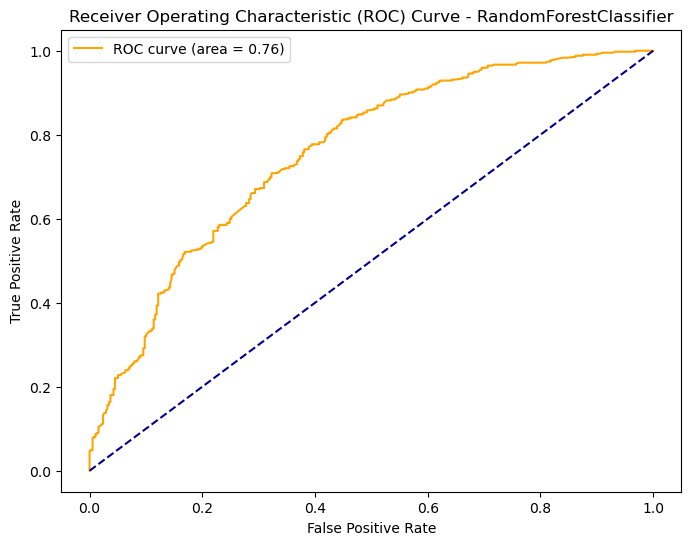

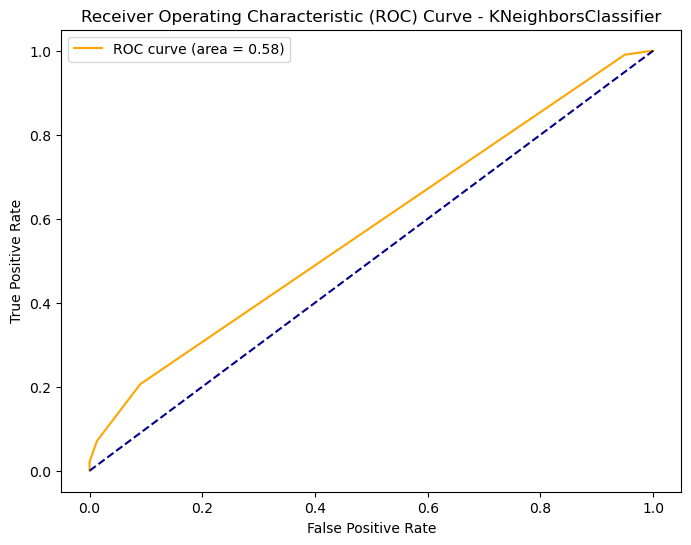

AttributeError: This 'SVC' has no attribute 'predict_proba'

In [41]:

# Assuming 'completed' is the positive class
pos_label = 1

# Loop through each classifier
for clf in classifiers:
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Get the probability estimates for the positive class
    y_probs = clf.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and ROC AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=pos_label)
    roc_auc = roc_auc_score(y_test, y_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {type(clf).__name__}')
    plt.legend()
    plt.show()